#### Import the basis libraries and the dataset

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
df = pd.read_csv('banknotes.csv')

In [0]:
df.head()

,variace,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


#### Transform and analyze the data

In [0]:
# Rescale the data (neural nets prefer input values to lie between 0 and 1)
from sklearn.preprocessing import MinMaxScaler

In [0]:
mms = MinMaxScaler()

In [0]:
df1 = pd.DataFrame(mms.fit_transform(df))

In [0]:
df1.columns = df.columns

In [0]:
df1.head()

,variace,skewness,curtosis,entropy,class
0,0.769004,0.839643,0.106783,0.736628,0.0
1,0.835659,0.820982,0.121804,0.644326,0.0
2,0.786629,0.416648,0.310608,0.786951,0.0
3,0.757105,0.871699,0.054921,0.450440,0.0
4,0.531578,0.348662,0.424662,0.687362,0.0


In [0]:
df1.describe()

,variace,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.539114,0.587301,0.287924,0.668917,0.444606
std,0.205003,0.219611,0.185669,0.191041,0.497103
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.379977,0.451451,0.159869,0.557821,0.000000
50%,0.543617,0.602168,0.254280,0.723929,0.000000
75%,0.711304,0.770363,0.364674,0.813171,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
# see how many banknotes are fake (610 in this case)
df1['class'].value_counts()

0.0    762
1.0    610
Name: class, dtype: int64

In [0]:
# explore how separable the data is, and how non-linear the decision boundaries are
sns.pairplot(df1,hue = 'class')

In [0]:
# divide the data into the training and testing parts
from sklearn.model_selection import train_test_split,cross_val_score

In [0]:
X = df1.drop('class',axis = 1).values
y = df1['class'].values

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
# for comparison, build standard machine learning algorithms, such as RFC and support vector classifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [0]:
model = SVC()

In [0]:
# perform cross validation to see how stable the result is in terms of different data splits 
cvs = cross_val_score(model,X,y)

In [0]:
cvs

array([1., 1., 1., 1., 1.])

In [0]:
model.fit(X_train,y_train)

In [0]:
from sklearn.metrics import classification_report

In [0]:
# as we can see, the performace is perfect for the support vector machine algorithm
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       148
         1.0       1.00      1.00      1.00       127

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



#### Import keras modules

In [0]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam,SGD, RMSprop

#### Logistic Regression implementation

In [0]:
K.clear_session()
model = Sequential()
model.add(Dense(1,input_shape = (4,),activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy',metrics = ['accuracy'],optimizer = 'sgd')

In [0]:
history = model.fit(X_train,y_train,epochs = 30)

In [0]:
result = model.evaluate(X_test,y_test)

In [0]:
result

[0.588638388893821, 0.7272727266224948]

In [0]:
historydf = pd.DataFrame(history.history,index = history.epoch)

In [ ]:
for k in history.history: print(k, ' = ', history.history[k])

Text(0.5, 1.0, 'Test accuracy and loss as a function of the number of epochs')

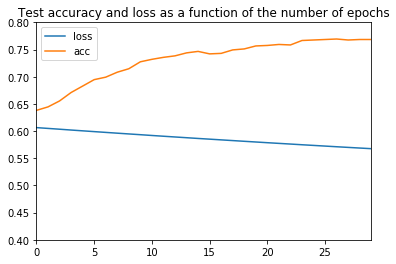

In [0]:
# plot the metrics (loss and accuracy) as functions of the number of epochs (iterations) 
historydf.plot(ylim=(0.4,0.8))
plt.title('Test accuracy and loss as a function of the number of epochs')

In [0]:
# same model but for a different learning rate
K.clear_session()
model = Sequential()
model.add(Dense(1,input_shape=(X.shape[1],),activation='sigmoid'))
model.compile(optimizer = SGD(lr = 0.3),loss = 'binary_crossentropy',metrics = ['accuracy'])

In [0]:
history = model.fit(X_train,y_train,epochs = 30)

In [0]:
df2 = pd.DataFrame(history.history,index = history.epoch)

In [0]:
df2.head()

,loss,acc
0,0.632527,0.644485
1,0.579130,0.711030
2,0.540536,0.815861
3,0.512270,0.825889
4,0.487310,0.851413


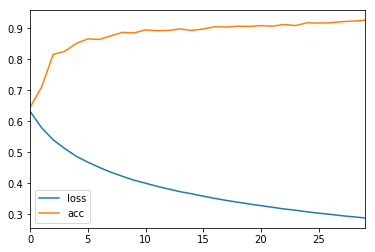

In [0]:
# as we can see from the plot below, the accuracy of the model has significantly improved
df2.plot()

In [0]:
# iterate over different learning rates to find the best one
dflist = []
learning_rate = [0.01,0.2,0.3,0.4,0.5]
for lr in learning_rate:
  K.clear_session()
  model = Sequential()
  model.add(Dense(1,input_shape = (4,),activation='sigmoid'))
  model.compile(optimizer = SGD(lr = lr),loss = 'binary_crossentropy',metrics=['accuracy'])
  h = model.fit(X_train,y_train,batch_size = 16,epochs = 10)
  dflist.append(pd.DataFrame(h.history,index = h.epoch))
  

In [0]:
# concatenate the dataframes in dflist into one dataframe
historydf = pd.concat(dflist,axis = 1)

In [0]:
metrics_reported = dflist[0].columns

In [0]:
# create a multi-index dataframe
idx = pd.MultiIndex.from_product([learning_rate,metrics_reported],names = ['lr','metric'])
historydf.columns = idx

In [0]:
historydf.head()

lr          0.01                0.20  ...      0.40      0.50          
metric      loss       acc      loss  ...       acc      loss       acc
0       0.685610  0.559708  0.567606  ...  0.762990  0.599964  0.670921
1       0.668854  0.559708  0.532500  ...  0.832270  0.514417  0.782133
2       0.658047  0.561531  0.504142  ...  0.867821  0.458201  0.828624
3       0.650761  0.569736  0.480664  ...  0.882407  0.416450  0.863263
4       0.645207  0.573382  0.458747  ...  0.896992  0.386927  0.877849

[5 rows x 10 columns]

<Figure size 864x576 with 0 Axes>

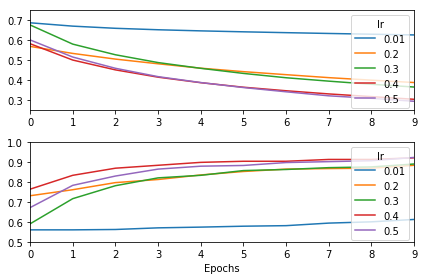

<Figure size 864x576 with 0 Axes>

In [0]:
# plot loss and accuracy for different learning rates
ax = plt.subplot(211)
historydf.xs('loss',axis = 1,level = 'metric').plot(ylim = (0.25,0.75),ax = ax)


ax = plt.subplot(212)
historydf.xs('acc',axis =1,level = 'metric').plot(ylim = (0.5,1),ax = ax)

plt.xlabel('Epochs')
plt.tight_layout()

plt.figure(figsize = (12,8))

In [0]:
# try different values of the batch size parameter
dflist = []
batch_sizes = [16,32,64,128]
for bs in batch_sizes:
  K.clear_session()
  model = Sequential()
  model.add(Dense(1,input_shape=(4,),activation='sigmoid'))
  model.compile(optimizer=SGD(lr = 0.5),loss='binary_crossentropy',metrics =['accuracy'])
  h = model.fit(X_train,y_train,batch_size=bs,epochs = 10)
  dflist.append(pd.DataFrame(h.history,index = h.epoch))
  
  
  

In [0]:
dfhistory = pd.concat(dflist,axis = 1)

In [0]:
metrics_reported = dflist[0].columns

In [0]:
idx = pd.MultiIndex.from_product([batch_sizes,metrics_reported],names = ['batch_size','metrics'])
dfhistory.columns = idx

In [0]:
dfhistory.head()

batch_size       16                  32   ...       64        128          
metrics         loss       acc      loss  ...       acc      loss       acc
0           0.634010  0.637192  0.604380  ...  0.560620  0.632486  0.692799
1           0.506451  0.820419  0.522357  ...  0.644485  0.609893  0.680948
2           0.445621  0.859617  0.482797  ...  0.680948  0.590151  0.746582
3           0.405004  0.878760  0.451134  ...  0.758432  0.572510  0.787603
4           0.374363  0.896080  0.428986  ...  0.793984  0.556775  0.814038

[5 rows x 8 columns]

In [0]:
# plot loss and accuracy as functions of the number of iterations for different batch sizes
ax = plt.subplot(211)
dfhistory.xs(key='loss',axis = 1, level = 'metrics').plot(ax = ax)

ax = plt.subplot(212)
dfhistory.xs(key = 'acc',axis = 1, level = 'metrics').plot(ax = ax)
plt.title('Loss')

plt.xlabel('Epoch')
plt.tight_layout()

In [0]:
# try a more complex neural net architecture
K.clear_session()
model = Sequential()
model.add(Dense(2,input_shape=(4,),activation ='relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(optimizer = RMSprop(lr=0.01),metrics = ['accuracy'],loss = 'binary_crossentropy')

h = model.fit(X_train,y_train,validation_split = 0.3,batch_size = 16,epochs = 20)
result = model.evaluate(X_test,y_test)

In [0]:
result

[0.12306774681264704, 0.9636363636363636]

In [0]:
# the summary() method allows to understand the neural net architecture more clearly
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [0]:
# using the model.layer attribute, define the input and output of the first layer
inp = model.layers[0].input
out = model.layers[0].output

In [0]:
# investigate the input and output
inp.shape

In [0]:
inp

In [0]:
out

In [0]:
features_function = K.function([inp],[out])

In [0]:
features_function

In [0]:
features = features_function([X_test])[0]

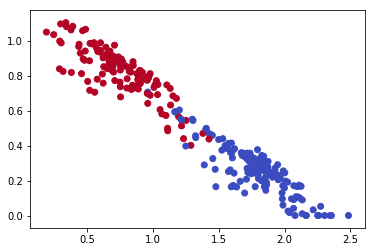

In [0]:
# plot the features (output of the first layer vs input of the first layer). Mark the classes with different colors.
plt.scatter(features[:,0],features[:,1],c=y_test,cmap = 'coolwarm')

In [0]:
# increase the complexity of the architecture
K.clear_session()

model = Sequential()
model.add(Dense(3, input_shape=(4,), activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.01),
              metrics=['accuracy'])

In [0]:
# Investigate the relationship between the input of the first layer and the output of the second layer 
inp = model.layers[0].input
out = model.layers[1].output
features_function = K.function([inp], [out])

# Visualize and explore how the neural net separates the two classes with each new iteration

plt.figure(figsize=(15,10))

for i in range(1, 26):
    plt.subplot(5, 5, i)
    h = model.fit(X_train, y_train, batch_size=16, epochs=1, verbose=0)
    test_accuracy = model.evaluate(X_test, y_test)[1]
    features = features_function([X_test])[0]
    plt.scatter(features[:, 0], features[:, 1], c=y_test, cmap='coolwarm')
    plt.xlim(-0.5, 3.5)
    plt.ylim(-0.5, 4.0)
    plt.title('Epoch: {}, Test Acc: {:3.1f} %'.format(i, test_accuracy * 100.0))

plt.tight_layout()